# Federated learning exercise

In this notebook I'll be implementing a basic federated learning scheme on some toy data. 

I'll be explaining my process and implementation along the way with interactive code and helpful plots. 

For neatness, some of my code has been pushed away into separate modules. These are utility methods for plotting, data preprocessing and so on - their implementation details are not relevant to the exercise, but I've done my best to keep them tidy and well-documented if you're curious. Those modules are: `fl_data_handling`, `fl_visualisation`, and `fl_monitoring`.


## Dataset

We'll use a simple and straightforward dataset for this exercise.

I'm using FashionMNIST because it's small enough to train well on CPU, while not as trivial as classic MNIST. In principle the code below should work for any image dataset of similar complexity.

Let's load the dataset and inspect a few samples:

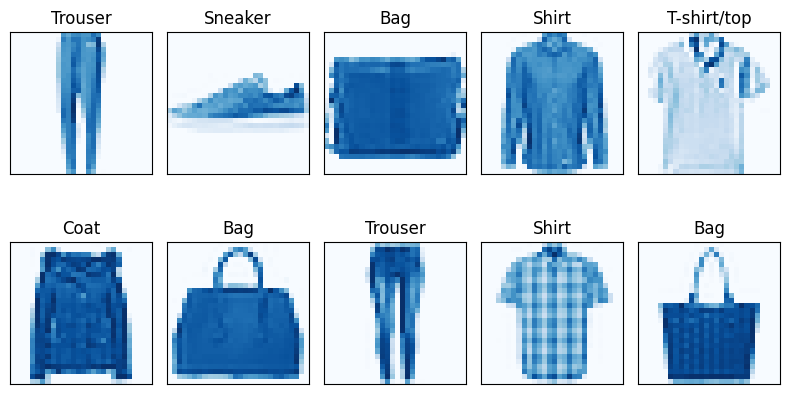

In [1]:
%matplotlib inline

# the usual imports:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets

from fl_data_handling import load_data
from fl_visualisation import inspect_data

dataset_class = datasets.FashionMNIST
# this dataset includes a pre-defined training and test set, but we'll
# split the original training set into training and validation on top of that.

# that split is handled in this function:
data_train, data_val, data_test = load_data(dataset_class, val_ratio=0.1)

DATA_IMG_DIMS = data_train.x.shape[1:]       # input image dimensions: (h,w)
DATA_NUM_CLASSES = len(data_train.classes)   # number of classes in the dataset

# load a few samples and their classes for visual inspection:
inspect_data(data_train, 10)

### Unfederated Learning

As a base case for comparison, I'll first train a small network on this data in the usual straightforward fashion.

We define the network architecture here, which will be re-used later for the federated learning case. Nothing fancy: just a couple of convolution-maxpool blocks followed by a few dense layers.

In [2]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class SimpleCNN(nn.Module):
    def __init__(self, 
                 img_dims: tuple[int,int] = DATA_IMG_DIMS,
                 num_classes: int = DATA_NUM_CLASSES):
        super().__init__()

        self.img_dims = img_dims
        self.num_classes = num_classes
        
        # we'll do two conv layers, each followed by a 2x2 max pool:
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        # pool again here

        # then reshape and feed into a stack of dense layers
        self.flatten = nn.Flatten()

        # calculate the number of units in the flattened feature vector,
        # based on the size and stride of our convolutions:
        # (is there an idiomatic way to do this in torch?)
        feature_dims = [((dim - 4) // 2 - 4) // 2  for dim in self.img_dims]
        num_spatial_units = np.prod(feature_dims) * 12
        self.dense1 = nn.Linear(num_spatial_units, 64)
        self.dense2 = nn.Linear(64, 32)
        self.dense3 = nn.Linear(32, self.num_classes)

    def forward(self, x):
        
        # add a channel dimension of size 1 (for grayscale data input):
        x = x[:,None,:,:]

        # conv, pool, relu:
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))

        # unroll into vector:
        x = self.flatten(x)
        
        # linear, relu:
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        
        # output logits:
        x = self.dense3(x)
        return x

    # this is a useful method for debugging that we'll use later,
    # although it is not needed until we get to the federated learning section.
    def checksum(self):
        """returns the sum of the hash of each layer's weights.
        used for testing/debugging the fed learning setting later."""
        param_sum = 0
        with torch.no_grad():
            for pname, param in self.named_parameters():
                param_sum += hash(torch.sum(param).item())
        # truncate to 6 places for brevity:
        return hash(param_sum) % int(1e6)

# print a summary of the network layers and parameter counts:
summary(SimpleCNN(), DATA_IMG_DIMS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 12, 8, 8]           1,812
         MaxPool2d-4             [-1, 12, 4, 4]               0
           Flatten-5                  [-1, 192]               0
            Linear-6                   [-1, 64]          12,352
            Linear-7                   [-1, 32]           2,080
            Linear-8                   [-1, 10]             330
Total params: 16,730
Trainable params: 16,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.06
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [3]:
# some training hyperparameters:
BATCH_SIZE = 64
NUM_EPOCHS = 3
INITIAL_LEARNING_RATE = 1e-1

DEVICE = 'cpu'
# when I finished at my last job they took away my GPU laptop :(

In [4]:
#### initialise and train baseline (un-federated) network

import time

from torch.utils.data import DataLoader
from torch import optim

from fl_data_handling import num_correct, get_val_metrics
from fl_monitoring import ProgressReporter
from fl_visualisation import inspect_model_outputs

# instantiate model:
baseline_model = SimpleCNN().to(DEVICE)

# I'm using vanilla SGD without momentum, because this simplifies
# the federated learning setting that we'll get to later.
opt = optim.SGD(baseline_model.parameters(), lr=INITIAL_LEARNING_RATE)

# scheduling learning rate decay is straightforward though:
scheduler = optim.lr_scheduler.LambdaLR(opt, lambda e: (1/3)**e)

# categorical crossentropy for multiclass classification:
loss_func = nn.CrossEntropyLoss()

# set up data loaders:
train_loader = DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
val_iter = iter(val_loader)

# and this is just a class that tracks loss/accuracy and prints them nicely:
progress = ProgressReporter(steps_per_epoch = len(train_loader),
                            num_epochs = NUM_EPOCHS,
                            time_interval = 0.5)

#### begin training!

for e in range(NUM_EPOCHS):
    for data in train_loader:
        batch_x, batch_y = data
        
        # forward pass:
        opt.zero_grad()
        batch_out = baseline_model(batch_x)

        # get cross-entropy loss:
        batch_loss = loss_func(batch_out, batch_y)
        
        # propagate gradients and update model:
        batch_loss.backward()
        opt.step()

        # get classification accuracy:
        train_acc = num_correct(batch_out, batch_y) / len(batch_out)
        # validate:
        val_loss, val_acc, val_iter = get_val_metrics(baseline_model, val_loader, val_iter, loss_func)
        
        # send metrics to progress tracker:
        progress.update(batch_loss.item(), train_acc, val_loss, val_acc, 
                        lr = scheduler.get_last_lr()[0])
        # (this will also print updates at regular intervals)
        
        # end of batch
        
    # end of epoch; ratchet down the learning rate
    scheduler.step()
progress.report()

print('\nFinished training.')

   Epoch 3/3   -   batch 844/844    -  100.0%    
[══════════════════════════╪═════════════════════════╪═══════════════════════════]  
    train loss: 0.4774 (acc: 82.48%)          val loss: 0.4811 (acc: 82.21%)      
    current learning rate: 1e-02    time per batch: 0.0131s


Finished training.


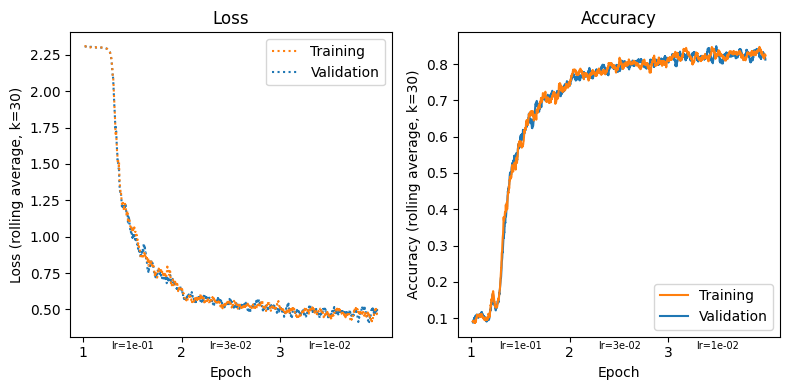

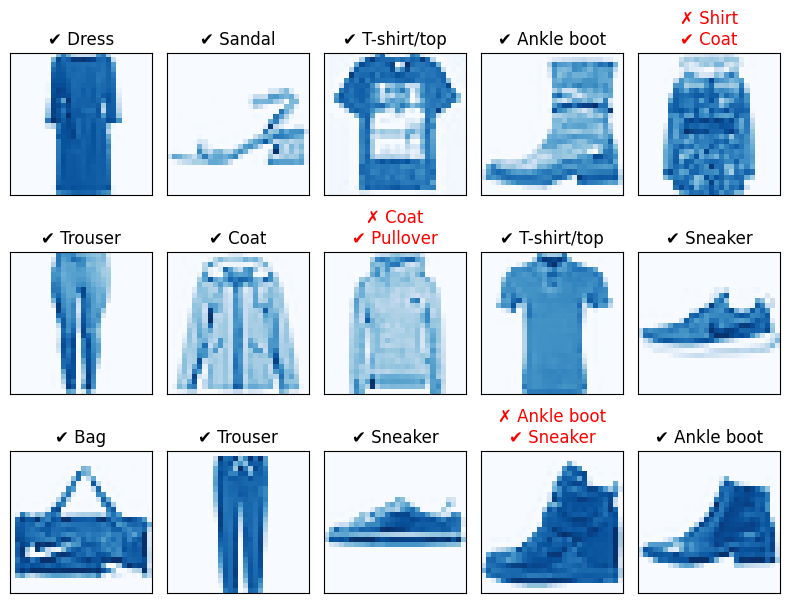

In [5]:
# show the loss curve: (smoothed out with a rolling average)
progress.plot_curves(rolling_window=30)

# inspect model predictions on test data:
# reload(fl_visualisation)
# from fl_visualisation import inspect_model_outputs, plot_metrics
inspect_model_outputs(baseline_model, data_test)

In [6]:
### evaluate on final test set:
from fl_data_handling import full_evaluation

test_loss, test_acc = full_evaluation(baseline_model, data_test, loss_func)
print(f'+ Test loss: {test_loss:.4f}'
     f'  |  accuracy: {test_acc:.2%}')

+ Test loss: 0.4993  |  accuracy: 81.86%


Looks pretty good. No overfitting or underfitting, and its classification errors are reasonable. We can notice that the network doesn't need any regularisation at its current size. 

That was the easy part - now we move onto federation.

## Federated Learning

In the federated learning setting, instead of the entire dataset being accessed by the machine that trains the model, the data is split across a number of 'client' machines that cannot share their data directly. Each client instead trains a local model on their private data, while periodically syncing with a 'global' model on a central server that aggregates their weight updates at each round.

To simulate this setting, we'll divide our training data into a number of partitions, and 'pretend' that each partition is private, only allowing access to the client agent that holds it.

There will also be a central server that holds only a validation and test set, used for monitoring the performance of the global model as updates are pushed from the clients.

### Data partitioning

We'll define some global parameters for the data partitioning process here, then perform the data split and examine the resulting class distribution.

In [7]:
NUM_CLIENTS = 5
# number of distributed client machines that will push updates to the shared model.
# the dataset is divided into this many partitions, representing private data
# held by each client.

HETEROGENEITY = 'weak'
# heterogeneity of class labels across data partitions. one of 'strong', 'weak', or 'none'.
  # 'none' is perfect homogeneity: stratify such that all partitions contain all class labels equally.
  # 'weak' randomly skews the distribution of class labels across partitions.
  # 'strong' has random skew and also drops some class labels from some partitions altogether.

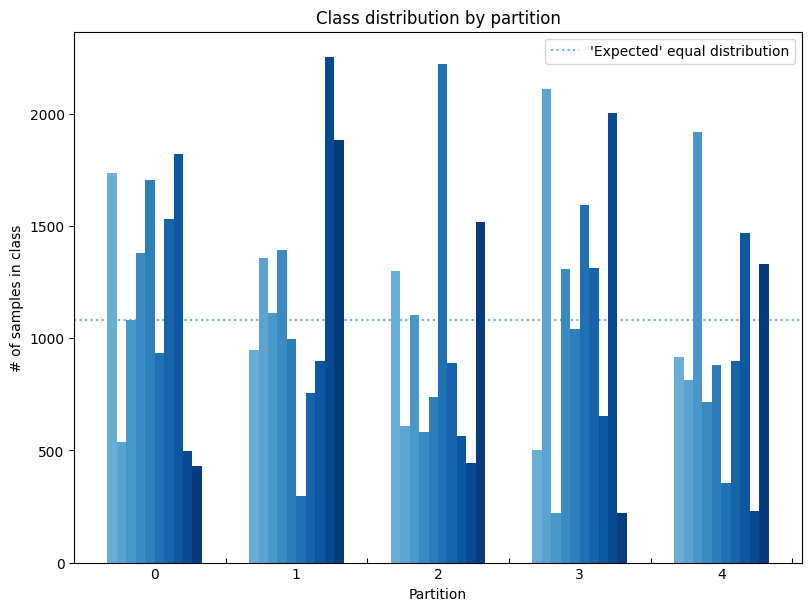

In [8]:
from fl_data_handling import partition_data
from fl_visualisation import plot_label_distribution

# partition the dataset into private chunks:
client_datasets = partition_data(data_train, 
                                 num_partitions=NUM_CLIENTS, 
                                 heterogeneity=HETEROGENEITY)

# note that we allow the central server to hold its own fraction of the data: 
# the original 'validation' data set that we used earlier in the baseline case, 
# as well as the FashionMNIST test set, that it will use for final evaluation.

# the data being partitioned across clients here is the 'training' set we defined earlier.

# inspect the split:
plot_label_distribution(client_datasets)

### Agent class definitions

For simulating the federated learning setting, I'll define `Server` and `Client` classes to represent the server and client machines respectively, so that their specific behaviour and local data can be clearly encapsulated.

In addition, I found it useful to define a third class called `Repository`, meant to represent the network interface *between* the server and clients. This isn't strictly necessary for the exercise to work, but I found it useful to demarcate the confidentiality bounds between them.

The rules of the encapsulation are as follows:
- The server and the clients cannot refer to each other directly.
- They can both push and pull from the repo, but the repo does not contain explicit pointers to either, so the server instance has no way to access any client instance, or vice versa.
- In addition, we make sure that any data contained in the repo consists only of raw numpy arrays (detached from the torch computation graph and copied to a new memory address), so that no state variables or graph dependencies hidden inside Torch objects are being passed around.

We start by defining the `Repository` class here. It's mostly a simple data container and has no methods of its own:

In [9]:
class Repository:
    """shared read/write environment between central server and clients,
        though has no methods and does not contain pointers to either.
        (just keeps tracks of how many clients have been subscribed)
    stores only raw values and numpy arrays, to ensure that no state 
        variables or graph dependencies hidden inside Torch objects are
        being passed around.
    anything contained in this class is no longer considered 'private'."""
    
    def __init__(self):
        
        self.model_spec = None # callable nn.Module class to initialise local models
        self.global_model_params = None # dict of param_names -> weight_arrays
        self.config = None # misc setup constants like validation ratio and batch size
        
        self.current_lr = None
        
        # keep track of how many clients are subscribed:
        self.num_clients = 0

        # clients will not share their individual per-class distributions
        # but they will share the total size of their datasets:
        # (so that the server can weight their updates proportionally)
        self.client_dataset_sizes = {}
        
        # and their local model gradients/parameters at each update:
        self.client_updates = {} # dict of (client_id) -> (gradients) mappings
        
        print(f'Shared repository initialised at: {hex(id(self))}')


#### Server

Next I define the `Server` class, to represent the machine that co-ordinates training and handles aggregating updates to the global model.

The server holds its own data partition, split across a central validation set (for evaluation in between training rounds) and a hold-out test set for final evaluation at the very end.

This class defines the following methods:
- `broadcast_global_model`: Send out the latest version of the global model parameters.
- `validate_global_model`: Evaluate the global model's performance against the centrally held validation/test dataset.
- `aggregate_updates`: Pull latest weights from client models and aggregate them into a new global model. For now, this is just a weighted average of the client models (proportional to the size of their datasets) - i.e. 'FedAvg'.

At init, the server initialises the global model's starting parameters and sends the model architecture specification out to the clients so they can build their own local model. It also contains a few configuration parameters that co-ordinate the training process like batch size and learning rate.

In [10]:
from torch import Tensor
from torch.utils.data import Dataset

from IPython.display import display_pretty, clear_output

class Server:
    """central server that holds the global model and aggregates
        weight updates from clients.
    contains validation and test data used to evaluate the global
        model as it is updated, though does not include its own
        optimiser.
    all actual gradient propagation is done on client machines,
        though the server co-ordinates the training process, """
    def __init__(self, model_spec: type, # a callable nn.Module class
                 val_data: Dataset,      # server-side validation data
                 test_data: Dataset,     # server-side test data
                 repo: Repository,       # initialised Repository object (see below)
                 device: str,
                 
                 # training configuration parameters to be passed to clients:
                 initial_lr: float,
                 batch_size: int,
                 num_epochs: int,
                 val_ratio: float):

        self.val_data, self.test_data = val_data, test_data
        self.val_loader = DataLoader(self.val_data, batch_size)
        self.test_loader = DataLoader(self.test_data, batch_size)
        self.repo = repo
        self.device = device

        self.model_spec = model_spec
        self.config = {'batch_size': batch_size,
                       'val_ratio': round(val_ratio,3),
                       'num_epochs': num_epochs}
        self.initial_lr = self.current_lr = initial_lr

        # initialise the global model:
        self.global_model = self.model_spec().to(self.device)
        
        print(f'Central server initialised at: {hex(id(self))}')
        print(f' - Global model constructed from spec: {self.model_spec}:')
        print(f'     with initialisation checksum: {self.global_model.checksum()}')



        self.global_epoch = 0
        self.progress = ProgressReporter # for tracking server-side metrics

    
    def broadcast_global_model(self, initial=False):
        """send global model weights to repository"""

        if initial:
            # first broadcast sends model architecture specification and training hyperparameters
            print(f'\n+ Depositing model specification to repo: {self.model_spec}'
                  f'\n    with training configuration dict: {self.config}')
            self.repo.model_spec = self.model_spec
            self.repo.config = self.config

        # to broadcast the global model parameters, we build a dict
        # that maps model parameter names to (detached) float arrays:
        named_params = self.global_model.named_parameters()
        self.repo.global_model_params = {name: params.detach().numpy().copy()
                                         for name, params in named_params}
        print(f'\n+ Central server broadcasting model params (checksum:{self.global_model.checksum()})')

        # send the latest learning rate as well:
        self.repo.current_lr = self.current_lr

    
    def aggregate_updates(self, verbose=False):
        """pull each client's published weights from repo, and take
        their weighted average to update the global model."""
        
        if verbose:
            prev_checksum = self.global_model.checksum()
            print(f'+ Aggregating updates to central model.'
                  f'  Current checksum: {prev_checksum}')
            
        # clients are weighted according to the size of their dataset,
        # i.e. those with more data contribute more to the model:
        total_samples = sum(self.repo.client_dataset_sizes.values())
        base_client_weightings = Tensor([self.repo.client_dataset_sizes[c] / total_samples 
                                    for c in range(self.repo.num_clients)])
        
        named_global_params = self.global_model.named_parameters()
        for pname, global_params in named_global_params:
            # for each parameter matrix, collect the respective client update dicts
            client_params_list = [Tensor(self.repo.client_updates[c][pname])
                             for c in range(self.repo.num_clients)]
            
            # stack them all up as one tensor, with first axis denoting client:
            client_params = torch.stack(client_params_list, dim=0)
            
            # then, for the weighted average, we need to take
            # the parameter-wise mean of all client models
            # weighted by the size of their respective datasets
            with torch.no_grad():

                client_weightings = base_client_weightings
                for dim in range(len(client_params.shape)-1):
                    # to broadcast the client weightings (a 1-d tensor)
                    # to each parameter tensor, for pointwise multiply,
                    # we need to add new dummy dimensions depending on the parameter shape
                    client_weightings = client_weightings[:,None]
                    # doing this in a loop is very ugly! 
                    # is there a better solution to this in torch?

                # "FedAvg":
                weighted_params = torch.mul(client_params, client_weightings)
                weighted_avg = torch.sum(weighted_params, dim=0)

                # assign to global model params of this layer:
                global_params.copy_(weighted_avg)
            
            if verbose:
                new_checksum = self.global_model.checksum()
                print(f'  Averaged layer params {pname:<15} '
                      f'New checksum: {new_checksum}')

                prev_checksum = new_checksum

    def validate_model(self, test=False, verbose=False, return_str=False):
        """runs the entire validation/test set through the current 
        global model and reports loss/accuracy metrics"""
        
        if not test:
            # run on validation set
            loader = self.val_loader
            set_name = 'val'
        else:
            # run on test set
            loader = self.test_loader
            set_name = 'test'
        
        losses, accs = [], []
        for b, batch in enumerate(loader):
            if (verbose) and ((b+1) % 25 == 0):
                display_pretty(f'+ Validating global model... {b+1}/{len(loader)}',  raw=True)
                clear_output(wait=True)
            batch_x, batch_y = batch
            batch_out = self.global_model(batch_x)
            losses.append(loss_func(batch_out, batch_y).item())
            accs.append(num_correct(batch_out, batch_y) / len(batch_out))
        avg_loss = np.mean(losses)
        avg_acc = np.mean(accs)

        str_output = (f'+ Central server {set_name} loss: {avg_loss:.4f}'
             f'  |  accuracy: {avg_acc:.2%}')
        
        if return_str:
            return (avg_loss, avg_acc), str_output
        else:
            print(str_output)
            return avg_loss, avg_acc

    # one additional misc method, so the server can act as a learning rate scheduler:
    def step_learning_rate(self, formula= lambda x: x/3):
        """progress the learning rate that is sent downstream to clients for training,
            according to the specified formula.
        intended to be called at the end of every global epoch."""
        self.current_lr = formula(self.current_lr)
        self.repo.current_lr = self.current_lr
    


#### Clients

Next I define the `Client` class. Client instances hold their own private data (which cannot be shared), and keep their own local models - with local optimisers that train on their private data - which they *are* allowed to share the parameters of.

This class defines the methods:
- `update_local_model`: Pull the latest parameters from the global model and use them to replace the parameters of the local model.
- `transmit_params`: Submit the current parameters of the local model to the server.
- `train_step`: Runs the local model on a single batch of private data and backpropagate gradients to update local model parameters. Also evaluates on local validation data, keeping a record of train/validation metrics at each training step. 
- `train_epoch`: Runs `train_step` over an entire epoch of private data.

Note that I've defined `train_step` and `train_epoch` as asynchronous functions - this isn't necessary for the simulation, but it lets me train all client models simultaneously rather than sequentially. This is also likely to be relevant in a practical setting.

At init, each client instance builds a local model (according to the architecture specification passed down by the server) and creates a train/validation split over its private dataset. It also pulls the training configuration parameters from the server (batch size, initial learning rate and so on). 

In [11]:
# next, define the client agents that hold their private data
# and keep local instances of the central server's global model
from torch.utils.data import random_split

import asyncio

from fl_monitoring import ProgressReporter
from fl_data_handling import get_class_distribution

class Client:
    """distributed client machine which holds a private data partition.
    cannot expose its data, but is allowed to share model weight updates."""
    def __init__(self, 
                 data: Dataset, # local partitioned data
                 client_id: int,  # unique integer to identify this client
                 repo: Repository,  # repository object to send/receive updates from
                 val_ratio: float = 0.2, # how much local data to keep for validation
                 device: str = 'cpu',
                 verbose: bool = True):
        self.data = data 
        self.id = client_id # just a unique integer to identify this client by
        self.repo = repo
        self.repo.num_clients += 1
        self.device = device

        # initialise local model:
        self.model = repo.model_spec().to(self.device)
        if verbose:
            print(f'+{self} initialised at: {hex(id(self))}')
            print(f'  Local model constructed with initial checksum: {self.model.checksum()}')

        # set up local data split and associated dataloaders:
        self.data_train, self.data_val = random_split(self.data, [1-VAL_RATIO, VAL_RATIO])

        self.train_loader = DataLoader(self.data_train, shuffle=True, batch_size=BATCH_SIZE)
        self.val_loader = DataLoader(self.data_val, shuffle=True, batch_size=BATCH_SIZE)
        self.train_iter, self.val_iter = iter(self.train_loader), iter(self.val_loader)

        # transmit our training set size to repo:
        self.repo.client_dataset_sizes[self.id] = len(self.data_train)
        print(f'  Reporting local training set size ({len(self.data_train)}) to repo\n')
        
        # we need the distribution of the local dataset's labels
        # so we can weight the losses appropriately
        self.class_distribution = get_class_distribution(self.data_train)
        self.class_weights = [0 for i in range(len(self.data.classes))]
        for cls, frac in self.class_distribution.items():
            self.class_weights[cls] = 1-frac

        self.current_lr = self.repo.current_lr
        self.loss_func = nn.CrossEntropyLoss(weight=Tensor(self.class_weights))
        self.opt = optim.SGD(self.model.parameters(), lr=self.current_lr)

        # for tracking local training progress:
        self.local_epoch = 0
        self.progress = ProgressReporter(steps_per_epoch = len(self.train_loader), 
                                         num_epochs=self.repo.config['num_epochs'],
                                         time_interval=0.5)
        
    def __repr__(self):
        return f'Client #{self.id}'
    
    def update_local_model(self, verbose=False):
        named_global_params = self.repo.global_model_params
        named_local_params = self.model.named_parameters()
        prev_checksum = self.model.checksum()
        
        with torch.no_grad():
            for name, local_params in named_local_params:
                global_params = named_global_params[name].copy()
                # we copy the globalparams to ensure that this model's local weights
                # are stored separately to the weights of every other model
                assert isinstance(global_params, np.ndarray)
                local_params.copy_(Tensor(global_params))

        if verbose:
            print(f'+ {self} local model (checksum:{prev_checksum}) synced with global parameters '
                  f'(new checksum:{self.model.checksum()})')

    
    def transmit_params(self, verbose=False):
        client_params = {}
        # iterate through local parameters and retrieve parameters/gradients:
        named_local_params = self.model.named_parameters()        
        for pname, params in named_local_params:
            client_params[pname] = params.detach().numpy().copy()
            # this chain of methods is required to ensure that the new array
            # is stored separately to the original

        # copy to repository:
        if verbose:
            print(f'+ {self} transmitting model weights (checksum: {self.model.checksum()}) to repo')
        self.repo.client_updates[self.id] = {pname:params for pname,params in client_params.items()}

    def update_learning_rate(self):
        """explicitly sets the learning rate of this client's SGD optimiser.
        needs to be done manually since it is the central server that
        co-ordinates learning rate scheduling."""
        self.current_lr = self.repo.current_lr
        for group in self.opt.param_groups:
            group['lr'] = self.current_lr
        
    async def train_step(self, 
                   batch: tuple[Tensor, Tensor] = None,
                   validate: bool = True,
                   transmit_weights: bool = False,
                   transmit_gradients: bool = False,
                   verbose: bool = False):
        """train local model for a single step on current dataloader.
        by default will draw a batch from the current train iterator,
            but can optionally be given a specific batch to feed through
            (e.g. when this method is called as part of a training loop)"""
        if batch is None:
            try:
                batch_x, batch_y = next(self.train_iter)
            except StopIteration:
                self.train_iter = iter(self.train_loader)
                batch_x, batch_y = next(self.train_iter)
        else:
            batch_x, batch_y = batch

        prev_checksum = self.model.checksum()

        self.opt.zero_grad()
        batch_out = self.model(batch_x)
        step_loss = self.loss_func(batch_out, batch_y)

        step_loss.backward()


        self.opt.step()

        new_checksum = self.model.checksum()
        if verbose:
            print(f'- {self} training step: {self.step}, checksums:{prev_checksum}->{new_checksum}')
        
        # validate:
        train_acc = num_correct(batch_out, batch_y) / len(batch_out)
        val_loss, val_acc, self.val_iter = get_val_metrics(self.model, self.val_loader, 
                                                      self.val_iter, self.loss_func)
        # record inside progress tracker:
        self.progress.update(step_loss.item(), train_acc, val_loss, val_acc, lr=self.current_lr)

        if verbose:
            print(f'  training loss: {self.progress.train_losses[-1]:.6f}')
            print(f'       accuracy: {self.progress.train_accs[-1]:.2%}')
            print(f'  updated local model with optimiser, new checksum: {self.model.checksum()}\n') 

    async def train_epoch(self, 
                    num_epochs:  int=1):

        self.progress.finished_epoch = False
        for e in range(num_epochs):
            for batch in self.train_loader:
                await self.train_step(batch)
                
                # very short amount of sleep required to make models train simultaneously:
                await asyncio.sleep(0.00001)
                
            self.local_epoch += 1
            self.progress.finished_epoch = True
        

### Simulation

Finally, with all these parts in place, we can begin the simulation by initialising the Server and Client objects, and set them training.

In [23]:
# these parameters are 'in-character' with respect to the simulation.
# they initialise the central server which broadcasts them to the clients
INITIAL_LR = 1e-1
BATCH_SIZE = 32
VAL_RATIO = 0.3
NUM_EPOCHS = 5
DEVICE = 'cpu'

# set up the repo:
repo = Repository()

# we'll let the central server hold a fraction of the data,
# to be used as a validation set to monitor training updates,
# and use the rest to represent training data 
# distributed across clients.

# then the server, which holds the model architecture spec, 
# and the 'global' validation and test data that we defined earlier
server = Server(SimpleCNN, data_val, data_test, repo,
                device = DEVICE,
                initial_lr = INITIAL_LR,
                batch_size = BATCH_SIZE, 
                val_ratio = VAL_RATIO, 
                num_epochs = NUM_EPOCHS)

# broadcast the global model's initialisation parameters:
server.broadcast_global_model(initial=True)

Shared repository initialised at: 0x7f752805a050
Central server initialised at: 0x7f752805a770
 - Global model constructed from spec: <class '__main__.SimpleCNN'>:
     with initialisation checksum: 844670

+ Depositing model specification to repo: <class '__main__.SimpleCNN'>
    with training configuration dict: {'batch_size': 32, 'val_ratio': 0.3, 'num_epochs': 5}

+ Central server broadcasting model params (checksum:844670)


In [24]:
# then, initialise the clients, which pull the model architecture spec
# from the repo to build their own local models:

clients = [Client(data = client_datasets[i],
                  client_id = i, 
                  repo = repo,
                  verbose=True) 
           for i in range(NUM_CLIENTS)]

# and pull the global model's parameters so they all match:
for client in clients:
    client.update_local_model(verbose=True)

+Client #0 initialised at: 0x7f752805b520
  Local model constructed with initial checksum: 599556
  Reporting local training set size (8155) to repo

+Client #1 initialised at: 0x7f7528059f30
  Local model constructed with initial checksum: 331516
  Reporting local training set size (8328) to repo

+Client #2 initialised at: 0x7f752805ab60
  Local model constructed with initial checksum: 576634
  Reporting local training set size (6978) to repo

+Client #3 initialised at: 0x7f752805b460
  Local model constructed with initial checksum: 587843
  Reporting local training set size (7672) to repo

+Client #4 initialised at: 0x7f752805a8c0
  Local model constructed with initial checksum: 285752
  Reporting local training set size (6668) to repo

+ Client #0 local model (checksum:599556) synced with global parameters (new checksum:844670)
+ Client #1 local model (checksum:331516) synced with global parameters (new checksum:844670)
+ Client #2 local model (checksum:576634) synced with global p

In [25]:
# now we'll try training the clients for one epoch before federating.
# this works perfectly fine if we run them sequentially,
# but I've made them all train simultaneously because it's more fun:

import asyncio
from fl_monitoring import JointProgressReporter

# this class combines the progress bars from multiple client reporters
# and outputs them all together:
joint_progress = JointProgressReporter([client.progress for client in clients])

# wrap all clients into a coroutine collection:
async def train_all_clients():
    tasks = [client.train_epoch() for client in clients]
    await asyncio.gather(*tasks)
    
# and run them all at once:
await train_all_clients()

# print one more report at end of epoch:
joint_progress.report()

print('\nFinished training epoch.')



Client #0:    Epoch 2/5   -    batch 0/255     -  20.0%     
[═══════════════╪───────────────┼───────────────┼───────────────┼────────────────]  
    train loss: 1.2664 (acc: 49.07%)          val loss: 1.2351 (acc: 53.52%)      

Client #1:    Epoch 2/5   -    batch 0/261     -  20.0%     
[═══════════════╪───────────────┼───────────────┼───────────────┼────────────────]  
    train loss: 0.9689 (acc: 61.22%)          val loss: 1.0184 (acc: 62.36%)      

Client #2:    Epoch 2/5   -    batch 0/219     -  20.0%     
[═══════════════╪───────────────┼───────────────┼───────────────┼────────────────]  
    train loss: 1.8885 (acc: 32.89%)          val loss: 1.8898 (acc: 31.86%)      

Client #3:    Epoch 2/5   -    batch 0/240     -  20.0%     
[═══════════════╪───────────────┼───────────────┼───────────────┼────────────────]  
    train loss: 0.8507 (acc: 70.83%)          val loss: 0.8081 (acc: 75.00%)      

Client #4:    Epoch 2/5   -    batch 0/209     -  20.0%     
[═══════════════╪─


Finished training epoch.


In [26]:
# then the models send their local updates to the repo:
for client in clients:
    client.transmit_params(verbose=True)

+ Client #0 transmitting model weights (checksum: 503509) to repo
+ Client #1 transmitting model weights (checksum: 524799) to repo
+ Client #2 transmitting model weights (checksum: 217243) to repo
+ Client #3 transmitting model weights (checksum: 354582) to repo
+ Client #4 transmitting model weights (checksum: 83656) to repo


In [27]:
# the server aggregates them into the global model
# according to our chosen strategy:
server.aggregate_updates(verbose=True)

+ Aggregating updates to central model.  Current checksum: 844670
  Averaged layer params conv1.weight    New checksum: 195331
  Averaged layer params conv1.bias      New checksum: 38851
  Averaged layer params conv2.weight    New checksum: 443908
  Averaged layer params conv2.bias      New checksum: 447300
  Averaged layer params dense1.weight   New checksum: 308745
  Averaged layer params dense1.bias     New checksum: 435913
  Averaged layer params dense2.weight   New checksum: 339278
  Averaged layer params dense2.bias     New checksum: 420239
  Averaged layer params dense3.weight   New checksum: 792463
  Averaged layer params dense3.bias     New checksum: 7567


In [28]:
# runs the global model on the central validation data:
val_metrics = server.validate_model(verbose=True)
joint_progress.global_update(*val_metrics)

# then broadcast the new global weights:
server.broadcast_global_model()

+ Central server val loss: 1.3789  |  accuracy: 49.97%

+ Central server broadcasting model params (checksum:7567)


In [29]:
# which the clients pick up to replace their existing local models:
for client in clients:
    client.update_local_model(verbose=True)

+ Client #0 local model (checksum:503509) synced with global parameters (new checksum:7567)
+ Client #1 local model (checksum:524799) synced with global parameters (new checksum:7567)
+ Client #2 local model (checksum:217243) synced with global parameters (new checksum:7567)
+ Client #3 local model (checksum:354582) synced with global parameters (new checksum:7567)
+ Client #4 local model (checksum:83656) synced with global parameters (new checksum:7567)



Client #0:    Epoch 5/5   -   batch 255/255    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
    train loss: 0.6651 (acc: 72.31%)          val loss: 0.6647 (acc: 72.73%)      

Client #1:    Epoch 5/5   -   batch 261/261    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
    train loss: 0.5141 (acc: 81.11%)          val loss: 0.5371 (acc: 80.75%)      

Client #2:    Epoch 5/5   -   batch 219/219    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
    train loss: 0.5601 (acc: 78.40%)          val loss: 0.5716 (acc: 77.45%)      

Client #3:    Epoch 5/5   -   batch 240/240    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
    train loss: 0.4802 (acc: 83.01%)          val loss: 0.5015 (acc: 81.90%)      

Client #4:    Epoch 5/5   -   batch 209/209    -  100.0%    
[═══════════════╪═


  Final evaluation:
+ Central server test loss: 0.6071  |  accuracy: 75.86%


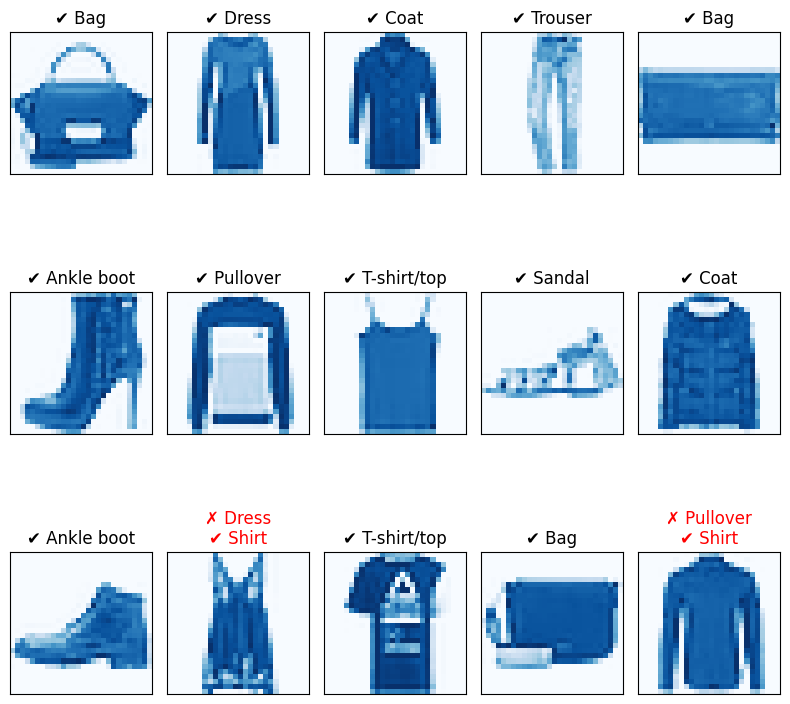

In [30]:
# let's continue and train on the remaining epochs,
# wrapping the whole federated aggregation process into one loop:

for e in range(1, NUM_EPOCHS):

    # set all clients to finish training their local epoch,
    # and wait for them to finish:
    await train_all_clients()

    # report progress at end of epoch
    joint_progress.report()

    
    #### federation step:
    
    # transmit local params, aggregate into new global model:
    for client in clients:
        client.transmit_params()
    server.aggregate_updates()

    # validate on local data:
    print(f'\n+ Validating global model...')
    val_metrics, val_str = server.validate_model(return_str=True)

    # report epoch-by-epoch validation loss during training:
    joint_progress.messages.append(f'Epoch {e+1}  (lr: {repo.current_lr:.0e}) \n{val_str}')

    # record metrics for later plotting:
    joint_progress.global_update(*val_metrics)
    
    if (e+1) < NUM_EPOCHS:
        # in between epochs,
        # broadcast the new model weights and learning rate:
        server.broadcast_global_model()
        server.step_learning_rate()
    
        # clients pull the latest weights and update to match:
        for client in clients:
            client.update_local_model()
            client.update_learning_rate()
    
        # then train next epoch and repeat
    else:
        # at final epoch, evaluate model on unseen test data:
        joint_progress.report()
        print(f'\n  Final evaluation:')
        final_eval = server.validate_model(test=True, verbose=False)
        inspect_model_outputs(server.global_model, server.test_data)

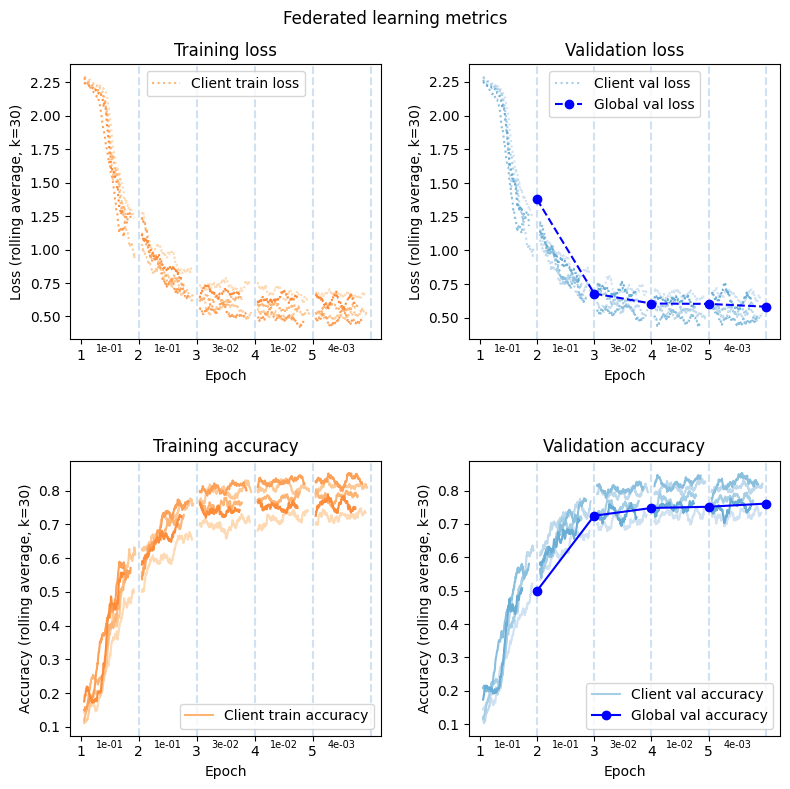

In [31]:
# inspect the combined progress of our federated training:
joint_progress.plot_curves(rolling_window=30)

The loss curves show the expected pattern. The global model's central validation loss initially lags behind the client-side loss, and the client losses have a tendency to 'snap' upward at the start of each epoch as they are synced with the global model before recovering (though this effect is masked by the rolling-average smoothing of these loss curves).

This looks like a success - we've set up a simulated federated learning setting, and co-ordinated a set of clients to jointly train a simple classification model on partitioned data, to a comparable degree of accuracy compared to baseline.

There's one more thing I want to do though. The aggregation strategy used so far has been what is called 'FedAvg' in the literature - just taking the weighted average of each client's parameters to be the new global model. Other, more sophisticated aggregation strategies are supposed to have useful properties and offer better convergence.

Below I try implementing 'FedProx', a simple extension of the 'FedAvg' strategy that regularises each client's local weight updates based on their distance from the global model.

In [32]:
# fedprox still uses weighted averaging at the aggregation step,
# but differs in adding a regularisation term to each client's local solver,
# proportional to the distance between the local and global models.

# I implement that here by subclassing Client to overwrite the train step:
class FedProxClient(Client):
    
    # at init, we accept an additional 'prox_factor' argument,
    # which is the multiplicative weighting of the prox loss term.
    def __init__(self, prox_factor, *args, **kwargs):
        self.prox_factor = prox_factor
        # initialise rest as Client:
        super().__init__(*args, **kwargs)

    # and we use this prox_factor attribute in the training step:
    async def train_step(self, 
                   batch: tuple[Tensor, Tensor],
                   validate: bool = True,
                   verbose: bool = False):
        """as Client.train_step, except that the loss additionally
        includes a regularisation term proportional to the distance
        between the client weights and those of the global model"""
        
        ### as before: run model on batch and compute loss
        batch_x, batch_y = batch
        self.opt.zero_grad()
        batch_out = self.model(batch_x)

        # only now we call this 'client loss', 
        # and it is only one half of the loss equation
        client_loss = self.loss_func(batch_out, batch_y)

        # the other half is this proximity loss term
        # that must iterate through the latest global model's parameters
        # and compare them to this client's current parameters
        layer_distances = []
        for pname, local_params in self.model.named_parameters():
            global_params = Tensor(self.repo.global_model_params[pname])
            distance = global_params - local_params
            # flatten each layer's parameters into a single, very long vector:
            layer_distances.append(torch.flatten(distance))
        distance_vector = torch.concatenate(layer_distances)
        
        # the proximity loss term is the L2 norm of this distance vector:
        prox_loss = torch.linalg.vector_norm(distance_vector, ord=2)
        # notably, this is equivalent to MSE between the local and global weights,
        # and could be considered a special kind of weight decay regularisation.
        
        # the total loss is a weighting of the two individual terms,
        # controlled by the 'prox_factor' attribute assigned at class init:
        weighted_prox_loss = self.prox_factor * prox_loss
        total_loss = client_loss + weighted_prox_loss
        total_loss.backward()

        #### the rest is all the same
        self.opt.step()

        # validate:
        if validate:
            train_acc = num_correct(batch_out, batch_y) / len(batch_out)
            val_loss, val_acc, self.val_iter = get_val_metrics(self.model, self.val_loader, 
                                                          self.val_iter, self.loss_func)
            # record inside progress tracker:
            self.progress.update(client_loss.item(), train_acc, val_loss, val_acc, 
                                 prox_loss = weighted_prox_loss.item(), lr=self.current_lr)


Client #0:    Epoch 5/5   -   batch 255/255    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
prox loss: 0.0000train loss: 0.7616 (acc: 68.90%)            val loss: 0.7805 (acc: 68.52%)            

Client #1:    Epoch 5/5   -   batch 261/261    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
prox loss: 0.0000train loss: 0.6152 (acc: 78.04%)            val loss: 0.5992 (acc: 78.74%)            

Client #2:    Epoch 5/5   -   batch 219/219    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
prox loss: 0.0000train loss: 0.6479 (acc: 76.01%)            val loss: 0.6812 (acc: 74.18%)            

Client #3:    Epoch 5/5   -   batch 240/240    -  100.0%    
[═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════]  
prox loss: 0.0000train loss: 0.5890 (acc: 79.70%)            val loss: 0.6054 (acc: 79.69%)         


  Final evaluation:
+ Central server test loss: 0.7075  |  accuracy: 72.41%

 Finished.


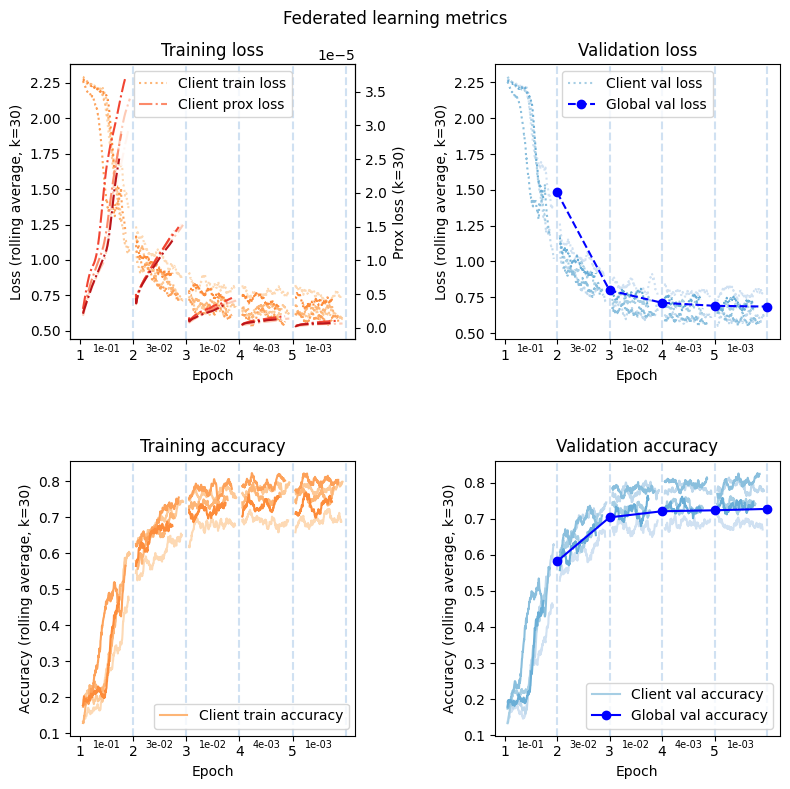

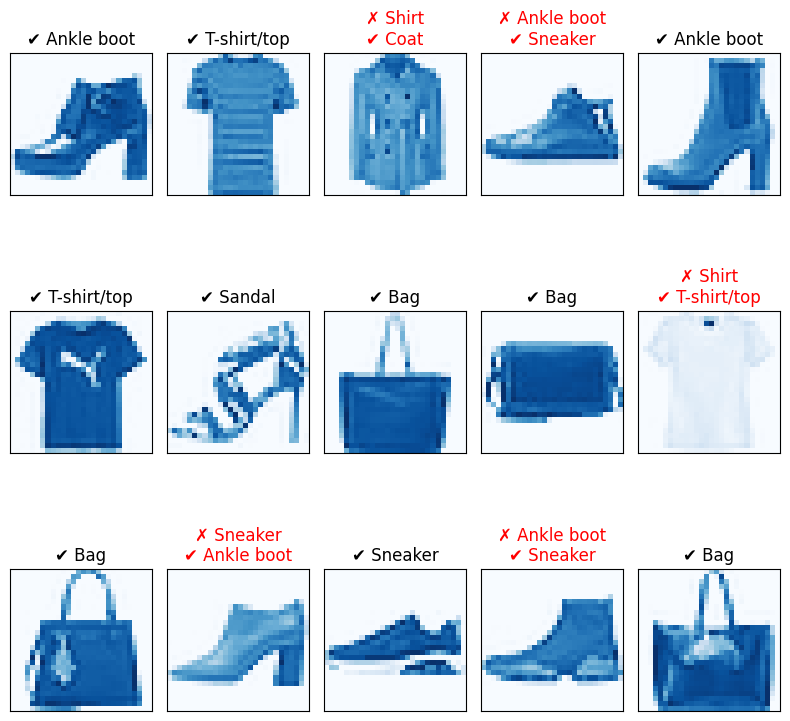

In [39]:
### then we can try re-starting the simulation with this additional fedprox modification.

# we need one new hyperparameter (equivalent to mu/2 in the FedProx paper):
PROX_FACTOR = 1e-5

# set the repo, server, and client up again from scratch, 
# with same data split and hyperparameters as before:
repo = Repository()

server = Server(SimpleCNN, data_val, data_test, repo,
                device = DEVICE,
                initial_lr = INITIAL_LR,
                batch_size = BATCH_SIZE, 
                val_ratio = VAL_RATIO, 
                num_epochs = NUM_EPOCHS)
server.broadcast_global_model(initial=True)

#### the one change: now our Clients are FedProxClients
clients = [FedProxClient(PROX_FACTOR, 
                         data = client_datasets[i],
                         client_id = i, 
                         repo = repo) 
            for i in range(NUM_CLIENTS)]
####

# all the other code is just as before

# sync with global model:
[client.update_local_model() for client in clients]

# set up progress tracker:
reload(fl_monitoring)
from fl_monitoring import JointProgressReporter
prox_joint_progress = JointProgressReporter([client.progress for client in clients])

# set up asynchronous training routine:
async def train_all_clients():
    tasks = [client.train_epoch() for client in clients]
    await asyncio.gather(*tasks)

# begin training:
for e in range(NUM_EPOCHS):

    await train_all_clients()
    prox_joint_progress.report()
    
    #### federation step:
    
    for client in clients:
        client.transmit_params()
    server.aggregate_updates()

    print(f'\n+ Validating global model...')
    val_metrics, val_str = server.validate_model(return_str=True)

    prox_joint_progress.messages.append(f'Epoch {e+1}  (lr: {repo.current_lr:.0e}) \n{val_str}')
    prox_joint_progress.global_update(*val_metrics)
    
    if (e+1) < NUM_EPOCHS:
        server.broadcast_global_model()
        server.step_learning_rate()
    
        for client in clients:
            client.update_local_model()
            client.update_learning_rate()
    
    else:
        # final epoch
        prox_joint_progress.report()
        print(f'\n  Final evaluation:')
        final_eval = server.validate_model(test=True, verbose=False)

print('\n Finished.')
prox_joint_progress.plot_curves(rolling_window=30)
inspect_model_outputs(server.global_model, server.test_data)

### I *think* this implementation is correct, though I haven't been able to get it to a
### better test accuracy than the vanilla FedAvg setup, regardless of my prox_factor tuning.
### best results might be achieved by adapting the weight of this term over training.

### Practical considerations not implemented

#### Secure aggregation
- My implementation separates the data partitions from the central server and from each other, but each client *does* share all of its local model's parameters with the server. 
- Especially for larger models, this is insufficiently private - it is often possible to recover individual training datapoints directly from a model's weights.
- As I understand it, most federated learning systems in practice use some type of 'secure aggregation' to further obfuscate or encrypt the local model parameters when they are transmitted to the server.
- I believe this is typically done by homomorphic encryption, stochastic masking, or differentially-private parameter perturbations - but I would need to research these approaches in more detail before implementing

#### Client co-ordination & robustness
- In practice it is common to draw/sample random subsets of the clients for training and local validation.
- I don't do that here (we train on all clients each round) but it would be a straightforward modification.
- In either case we would also want to consider network failure and the protocol's robustness against clients dropping out during the training process
- My implementation also has no safeguards against theoretically malicious clients that could deliberately poison the model by supplying adversarial weight updates.

#### Stateful optimisation
- I have deliberately chosen a stateless optimiser (vanilla SGD) to simplify the aggregation step
- The inclusion of momentum or per-parameter learning rates (e.g. with RMSProp or Adam) presumably follows similar logic to the layer-wise averaging of weight parameters themselves, but I have not researched this in detail

#### Regularisation / batch-norm
- This toy model works fine without any regularisation because it's so small
- For larger models, weight decay or dropout can probably be handled entirely during client-side training (i.e. no need for communication with server or explicit aggregation approach)
- Probably helps a lot in practice, my intuition is that it would help client models all converge in the same 'direction'
- Batch-normalisation is likewise not needed for this particular model, but is probably very important in practice given the domain gap between heterogeneous client datasets

